In [4478]:
from pandas import Series
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn import metrics

In [4479]:
# функция для анализа категориальных и номинативных переменных
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='default', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [4480]:
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Первое, что сделал - это удалил все колонки с нечисловыми значениями и попробовал запустить модель. Score - 0.68488. Будем считать это отправной точкой.

# Импорт данных

In [4481]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4482]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [4483]:
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head())
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head())

Размерность тренировочного датасета:  (73799, 20)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


Размерность тестового датасета:  (36349, 20)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [4484]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# Описание содержимого

1. client_id - идентификатор клиента

2. education - уровень образования

3. sex - пол заемщика

4. age - возраст заемщика

5. car - флаг наличия автомобиля

6. car_type - флаг автомобиля иномарки

7. decline_app_cnt - количество отказанных прошлых заявок

8. good_work - флаг наличия “хорошей” работы

9. bki_request_cnt - количество запросов в БКИ

10. home_address - категоризатор домашнего адреса

11. work_address - категоризатор рабочего адреса

12. income - доход заемщика

13. foreign_passport - наличие загранпаспорта

14. sna - связь заемщика с клиентами банка

15. first_time - давность наличия информации о заемщике

16. score_bki - скоринговый балл по данным из БКИ

17. region_rating - рейтинг региона

18. app_date - дата подачи заявки

19. default - флаг дефолта по кредиту

In [4485]:
print(f'Всего в датасете {data.isnull().any().sum()} столбцов с пропущенными значениями.')
# посчитаем сколько колонок с пропущенными значениями

Всего в датасете 1 столбцов с пропущенными значениями.


In [4486]:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

# Предварительный анализ 
В тренировочном датасете 73799 строк, в тестовом - 36349. В общей сложности представлены данные о 110 148 клиентах. Всего 19 предикторов, из них 1 - временной ряд, 6 бинарных, 7 категориальных и 5 числовых. Всего пропусков 478 (или 0,43 % от общего количества строк), все пропуски в переменной education.

In [4487]:
# внесем данные из резюме в списки 
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (5+1 = 6)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (sample не включаем в список, так как мы сами его добавили) (7)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка (5)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

In [4488]:
# Действие относится к самой простой модели, для которой данные вообще не обрабатывались! 
# data.drop(['app_date', 'education', 'sex','car','score_bki', 'car_type', 'good_work', 'foreign_passport'], axis='columns', inplace=True)

Будем двигаться не совсем по порядку (не по порядку расположения столбцов). В описании к соревнованию указано, что на платформе составлен "так называемый baseline" будем придерживаться его.

In [4489]:
freq = data["region_rating"].value_counts(normalize = True)
data["region_rating_freq"] = data["region_rating"].map(freq)
data[["region_rating", "region_rating_freq"]].head(6)

,region_rating,region_rating_freq
0,50,0.372054
1,50,0.372054
2,50,0.372054
3,40,0.162935
4,80,0.155881
5,50,0.372054


# 1. education

In [4490]:
data['education'].value_counts(dropna = False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

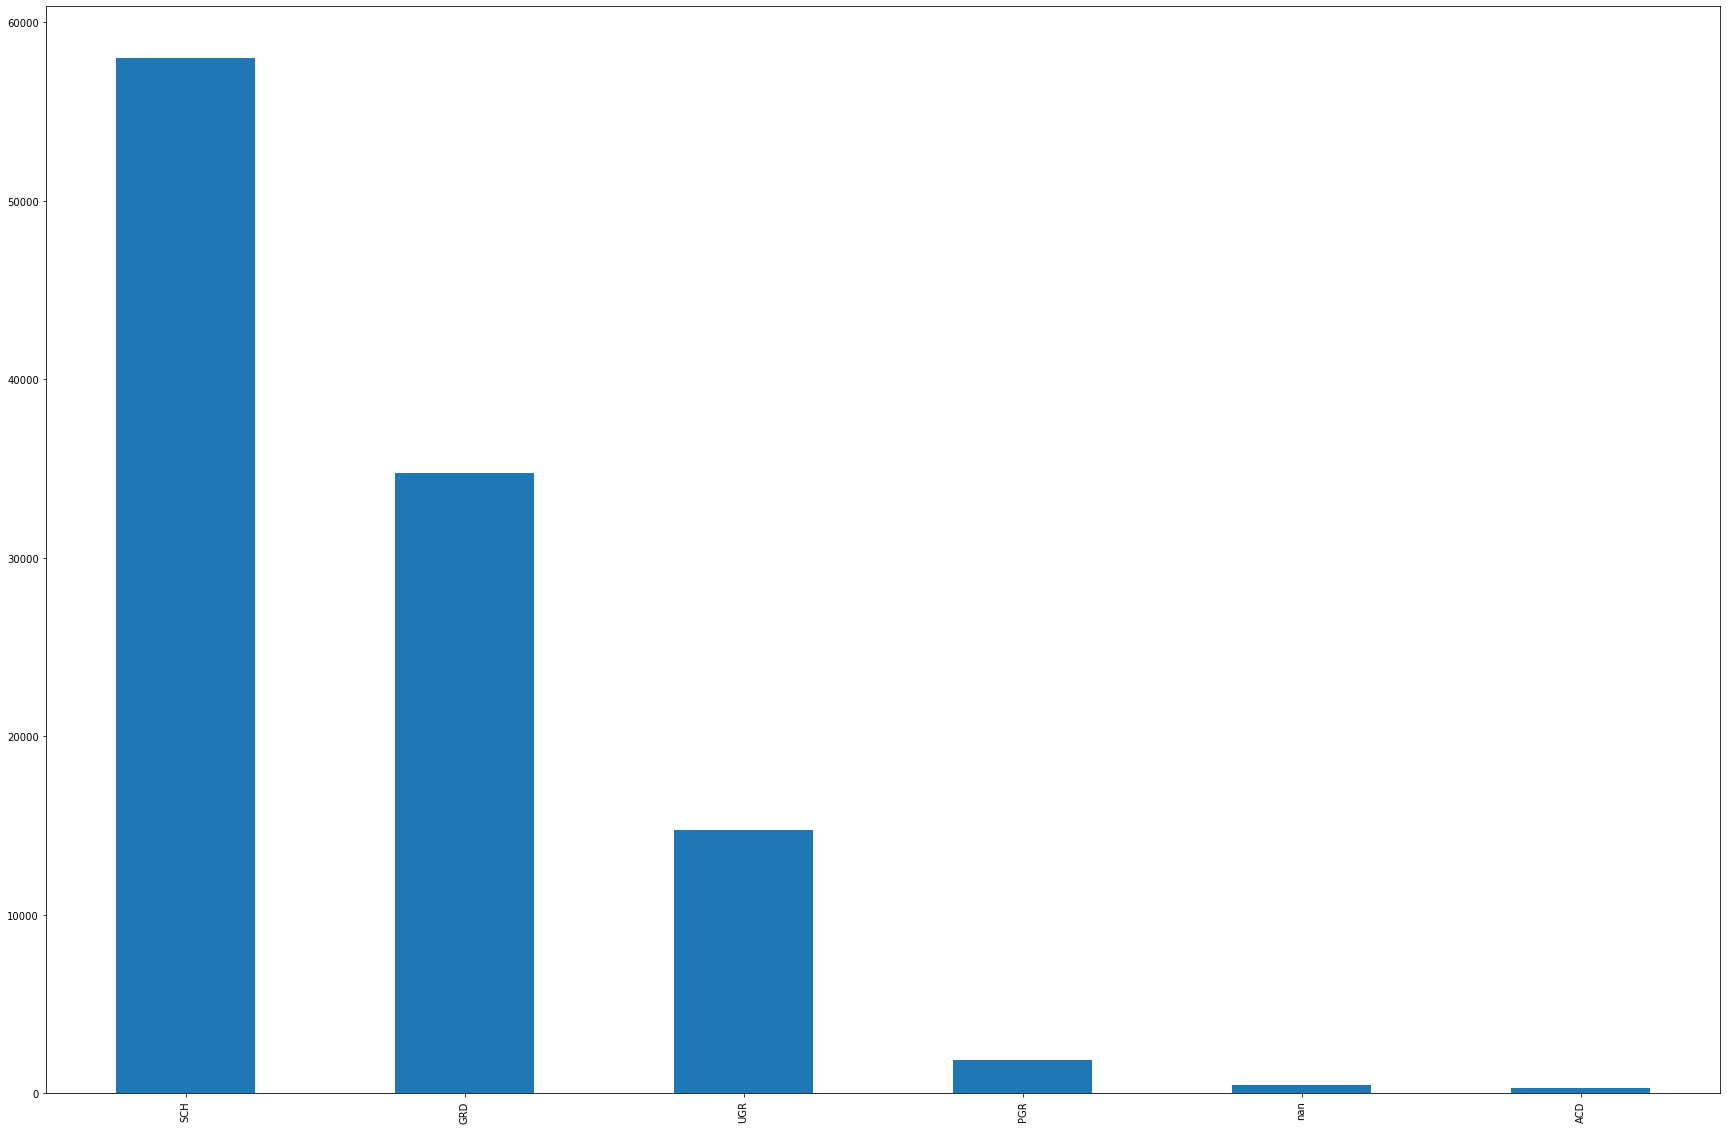

In [4491]:
# Визуализируем данные в столбце "education"
data['education'].value_counts(dropna = False).plot.bar()

Наибольшее количество клиентов имеет школьное образование. Необходимо заполнить пропущенные значения

Визуализация взаимосвязи образования и значения нашей целевой переменной.

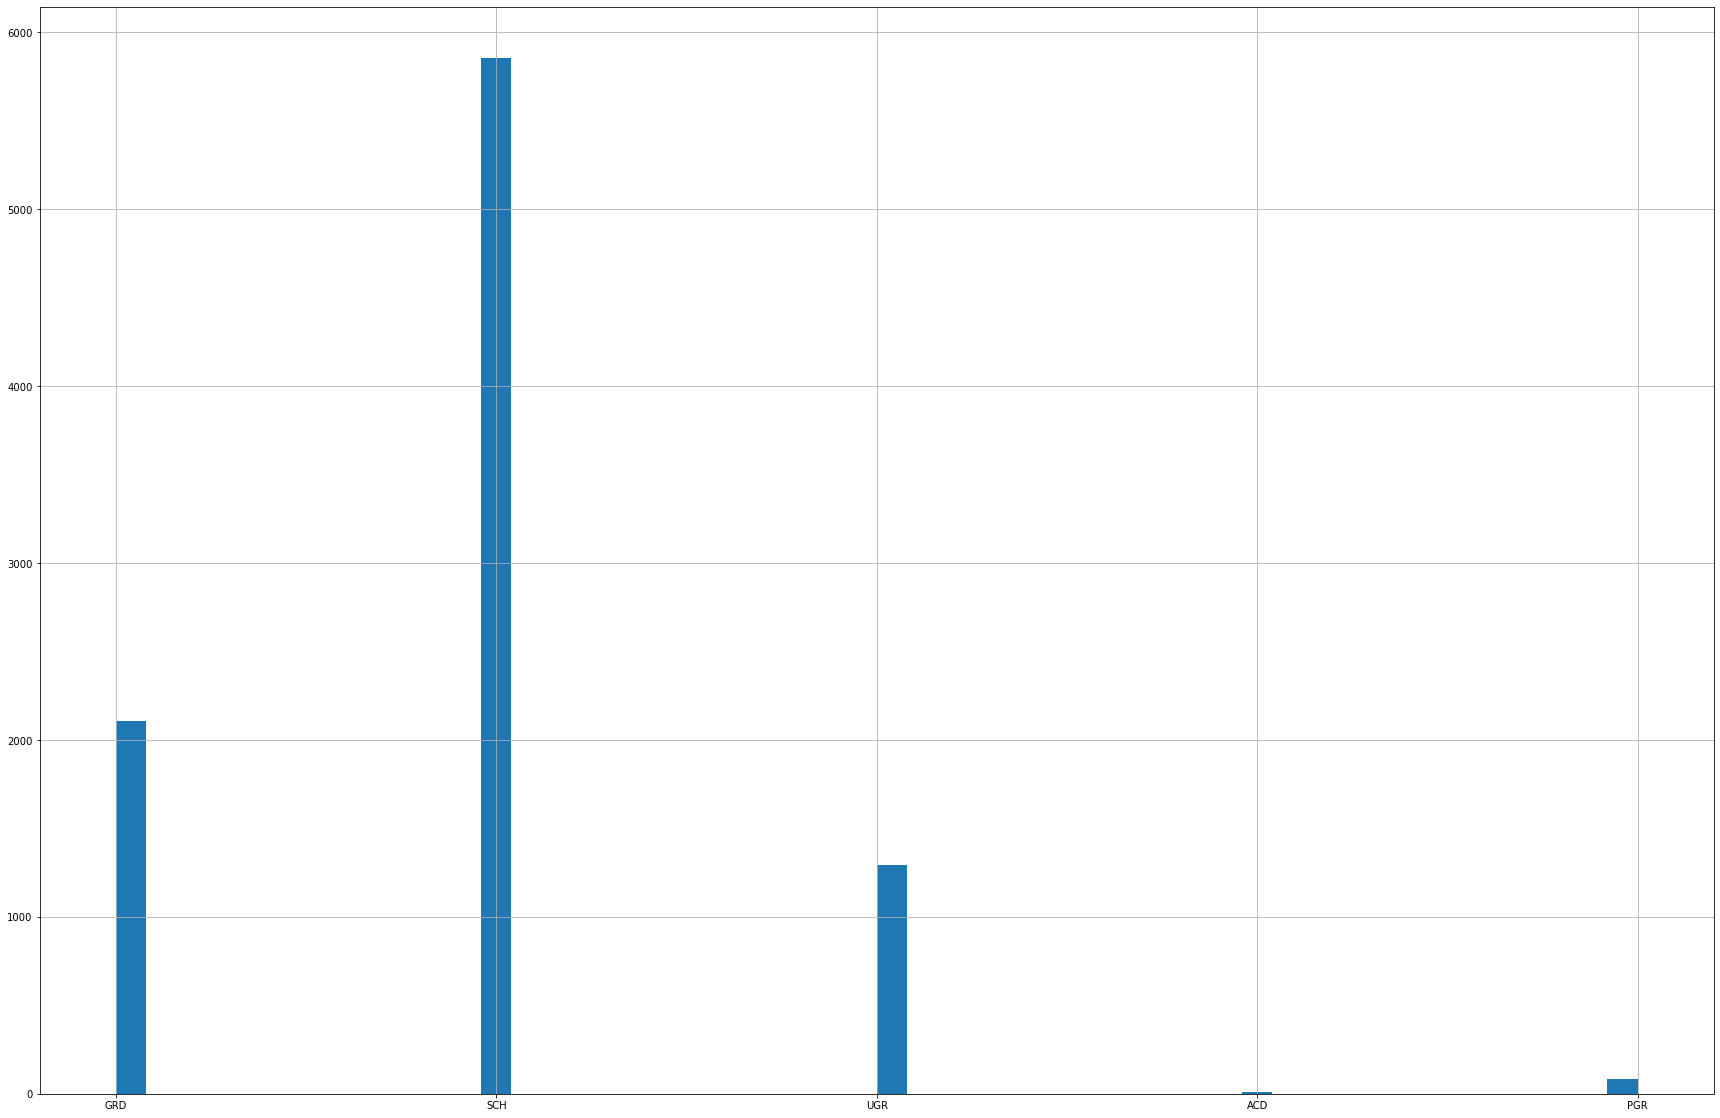

In [4492]:
data['education'][data['default'] == 1].hist(bins=50)

Ничего удивительного не обнаружилось, ввиду того, что наиболее распространенным значением является SCH, соответственно наиболее частые дефолты по кредитам встречаются именно с этой категорией клиентов.

Взаимосвязь образования и пола клиента.

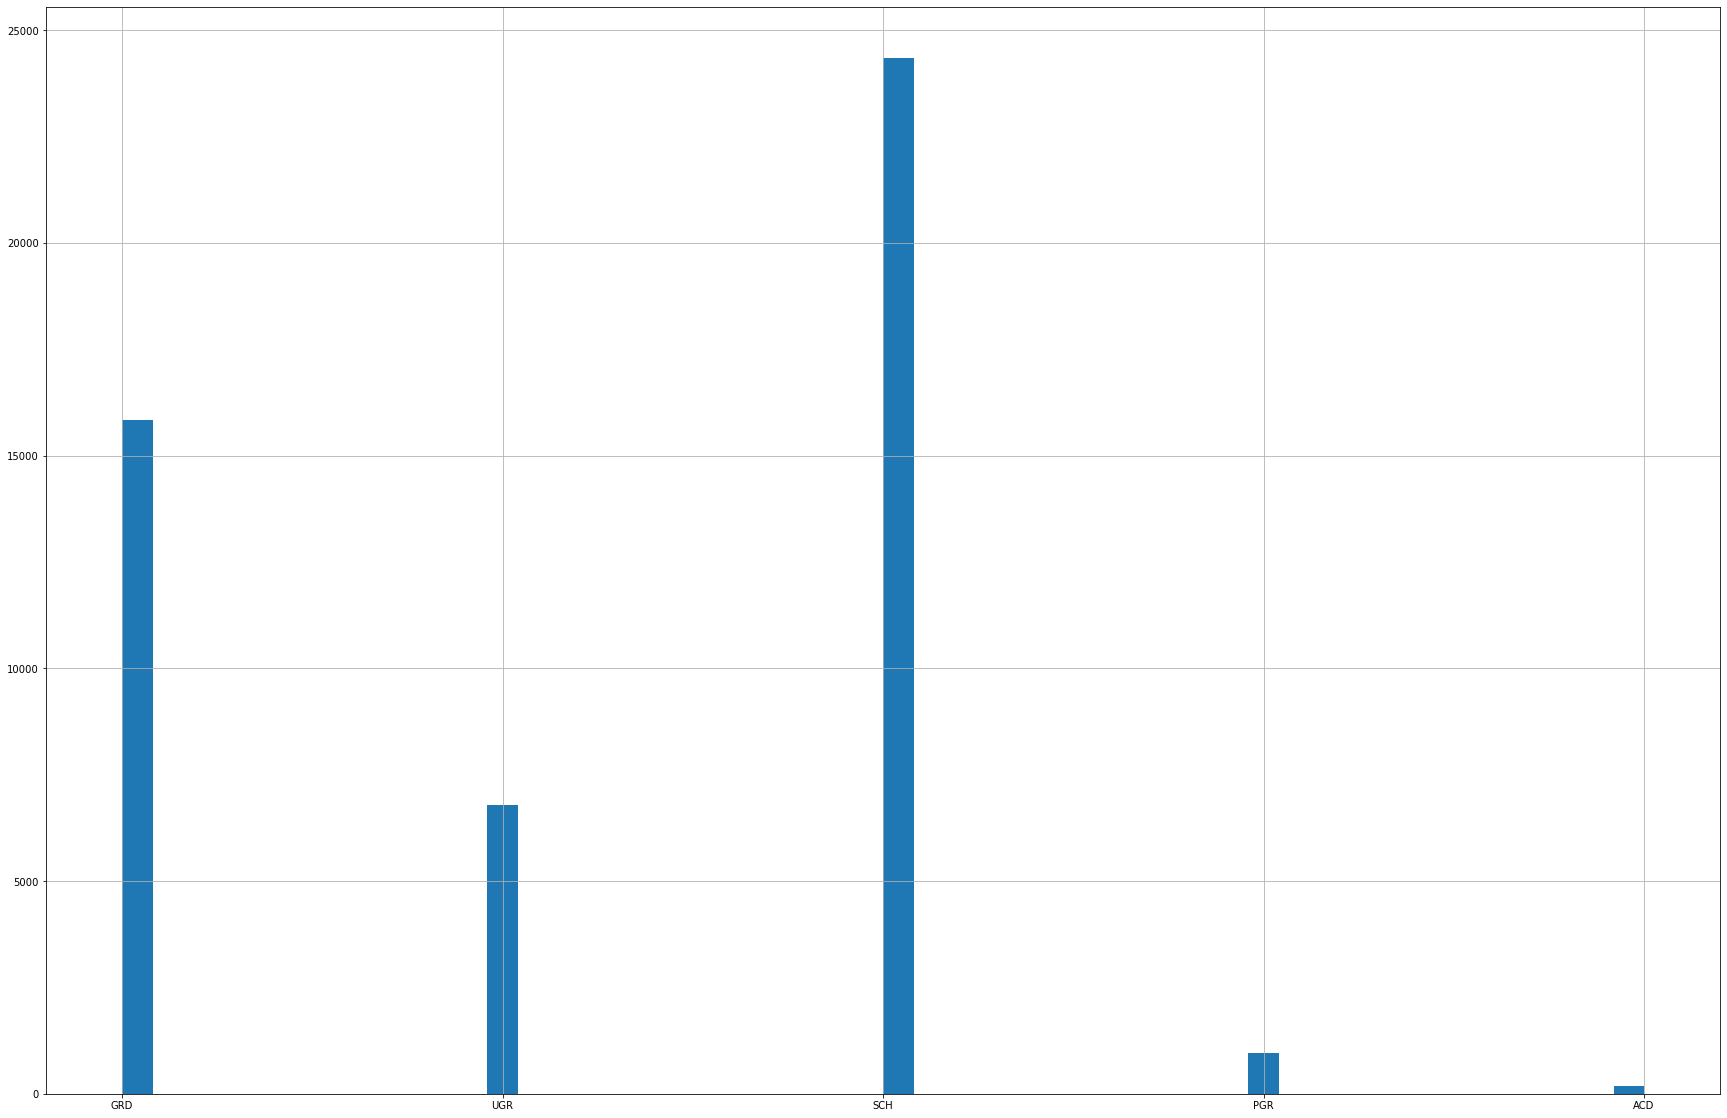

In [4493]:
data['education'][data['sex'] == 'M'].hist(bins=50)

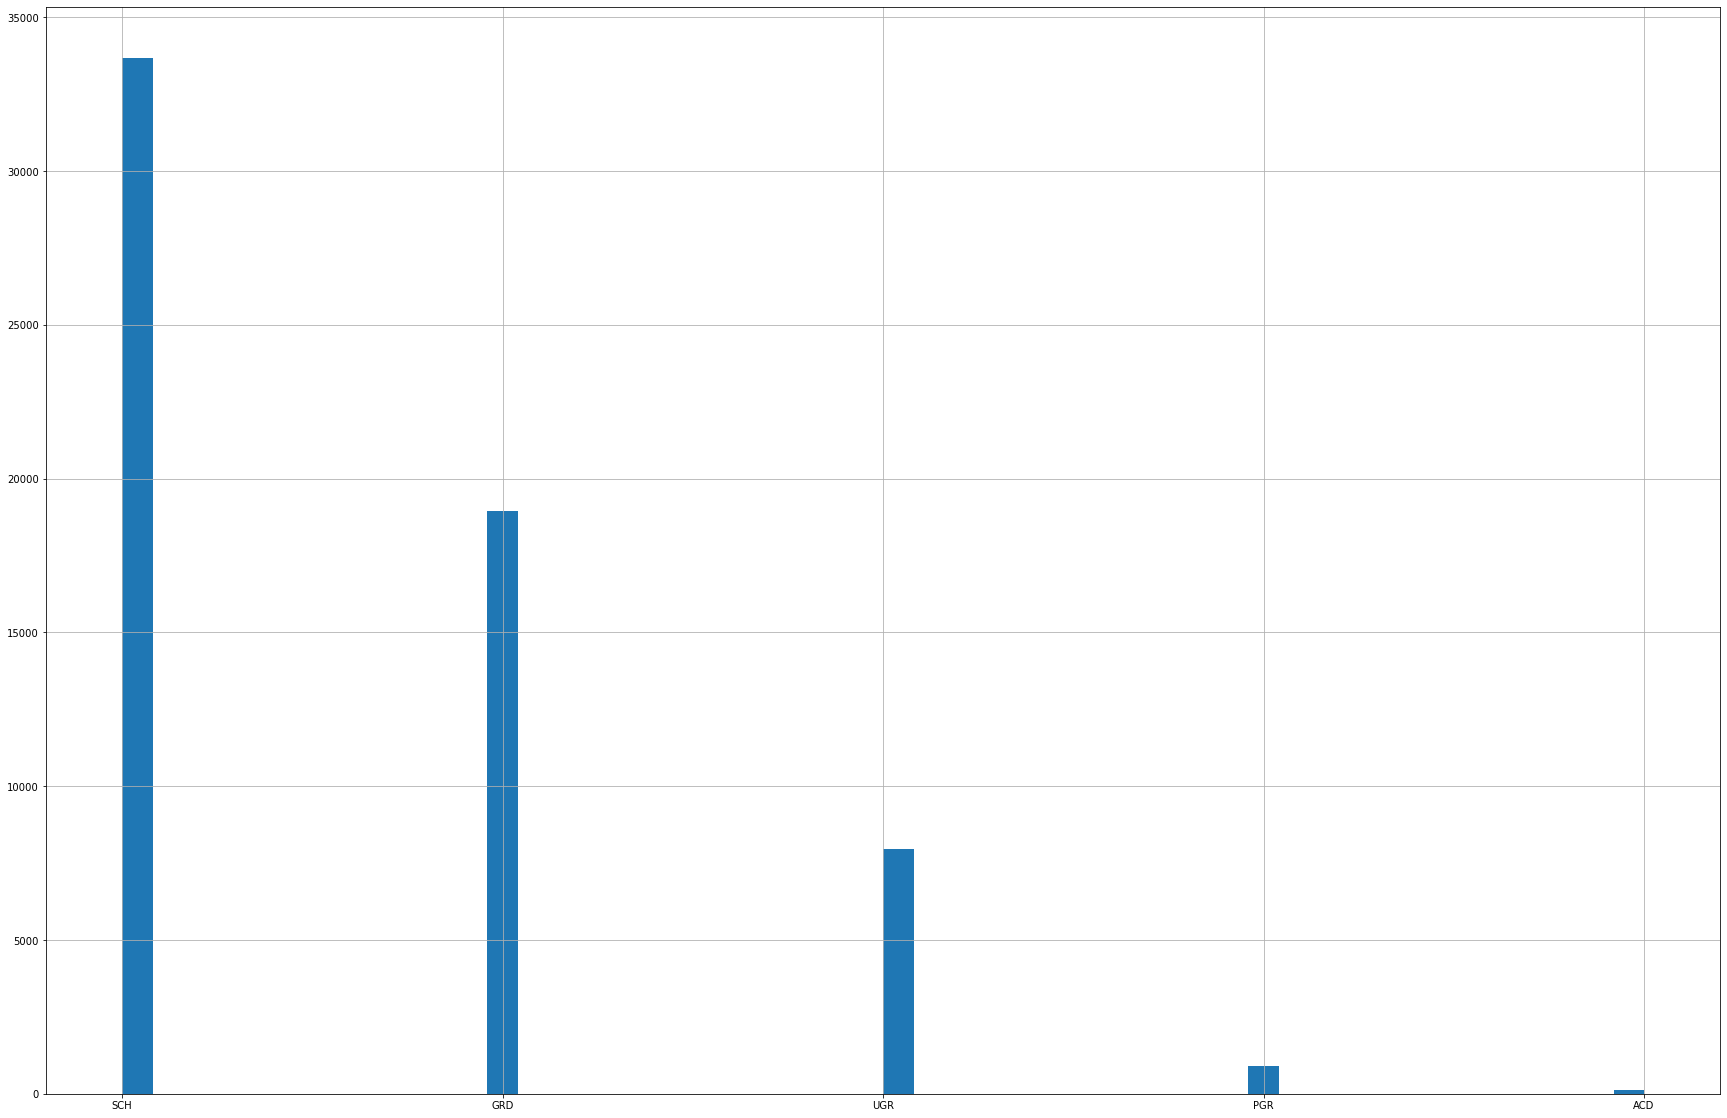

In [4494]:
data['education'][data['sex'] == 'F'].hist(bins=50)

Здесь можно увидеть, что среди женщин больше клиентов со школьным образованием.  

Зависимость образования и дохода.

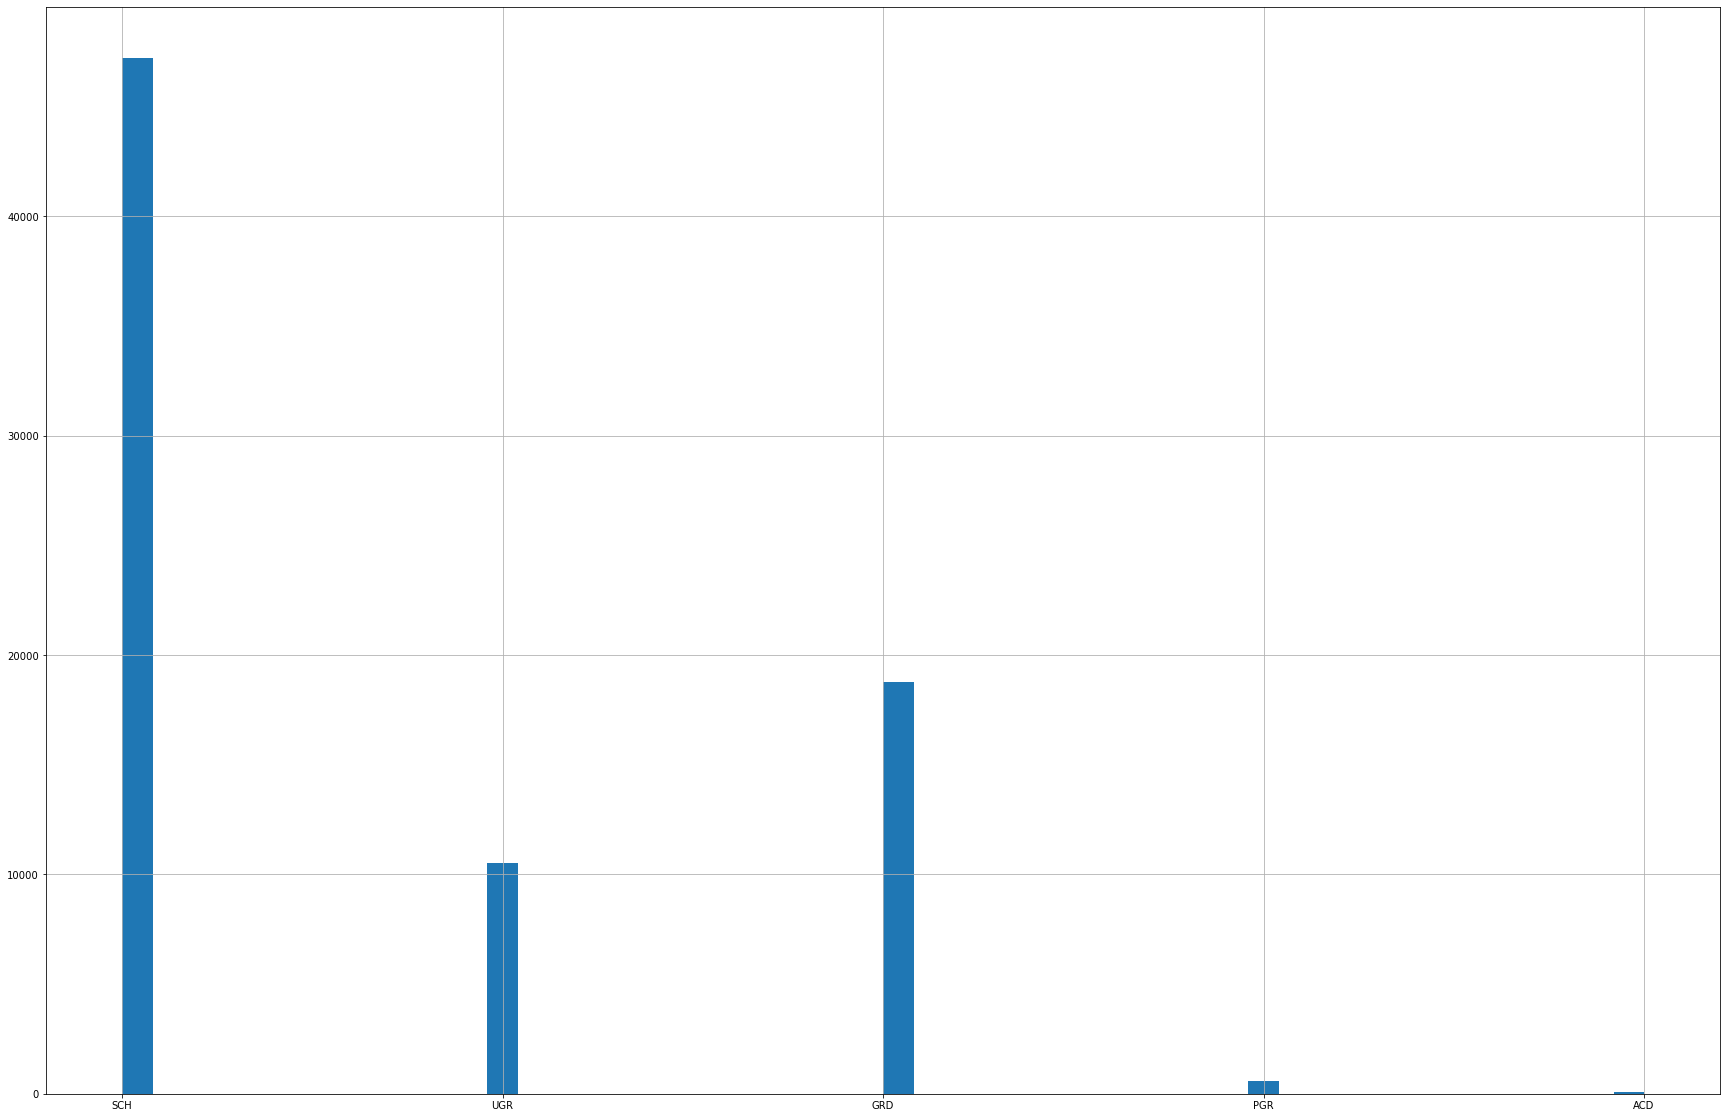

In [4495]:
data['education'][data['income'] < data['income'].mean()].hist(bins=50)

Наибольшее количество клиентов с доходом меньше среднего имеют школьное образование.


Попробуем заполнить пропущенные значения с учетом полученных наблюдений.


In [4496]:
data['education'] = np.where((data['sex'] == 'F') & (data['income'] < data['income'].mean()) & (data['education'].isna()), 'SCH', data['education'])

In [4497]:
# Проверим
data['education'].value_counts(dropna = False)

SCH    58195
GRD    34768
UGR    14748
PGR     1865
ACD      291
NaN      281
Name: education, dtype: int64

У нас осталось 281 пропущенное значение. Заполним их следующим по популярности значением.

In [4498]:
data['education'] = data['education'].fillna('GRD')

In [4499]:
# Проверим
data['education'].value_counts(dropna = False)

SCH    58195
GRD    35049
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Пропущенных значений больше нет. 

Среди количественных переменных можно выделить score_bki.

# 2. app_date

In [4500]:
import datetime as DT
# Преобразуем формат признака
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

In [4501]:
start_tr = data.app_date.min()
end_tr = data.app_date.max()
start_tr,end_tr

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [4502]:
data['day_num'] = data.app_date - data.app_date.min()
data['day_num'] = data['day_num'].apply(lambda x: str(x).split()[0])
data['day_num'] = data['day_num'].astype(int)

In [4503]:
data.app_date = data.app_date.astype(int)

In [4504]:
data.app_date.value_counts()

1395100800000000000    1491
1395187200000000000    1363
1395014400000000000    1350
1396224000000000000    1317
1396828800000000000    1296
                       ... 
1397952000000000000     359
1389052800000000000     349
1388707200000000000     313
1388620800000000000     204
1388534400000000000      56
Name: app_date, Length: 120, dtype: int64

In [4505]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           110148 non-null  int64  
 1   app_date            110148 non-null  int64  
 2   education           110148 non-null  object 
 3   sex                 110148 non-null  object 
 4   age                 110148 non-null  int64  
 5   car                 110148 non-null  object 
 6   car_type            110148 non-null  object 
 7   decline_app_cnt     110148 non-null  int64  
 8   good_work           110148 non-null  int64  
 9   score_bki           110148 non-null  float64
 10  bki_request_cnt     110148 non-null  int64  
 11  region_rating       110148 non-null  int64  
 12  home_address        110148 non-null  int64  
 13  work_address        110148 non-null  int64  
 14  income              110148 non-null  int64  
 15  sna                 110148 non-nul

# 3. sex 

Общеизвестный факт - женщины более аккуратны при пользовании кредитными продуктами. Попробуем это использовать.

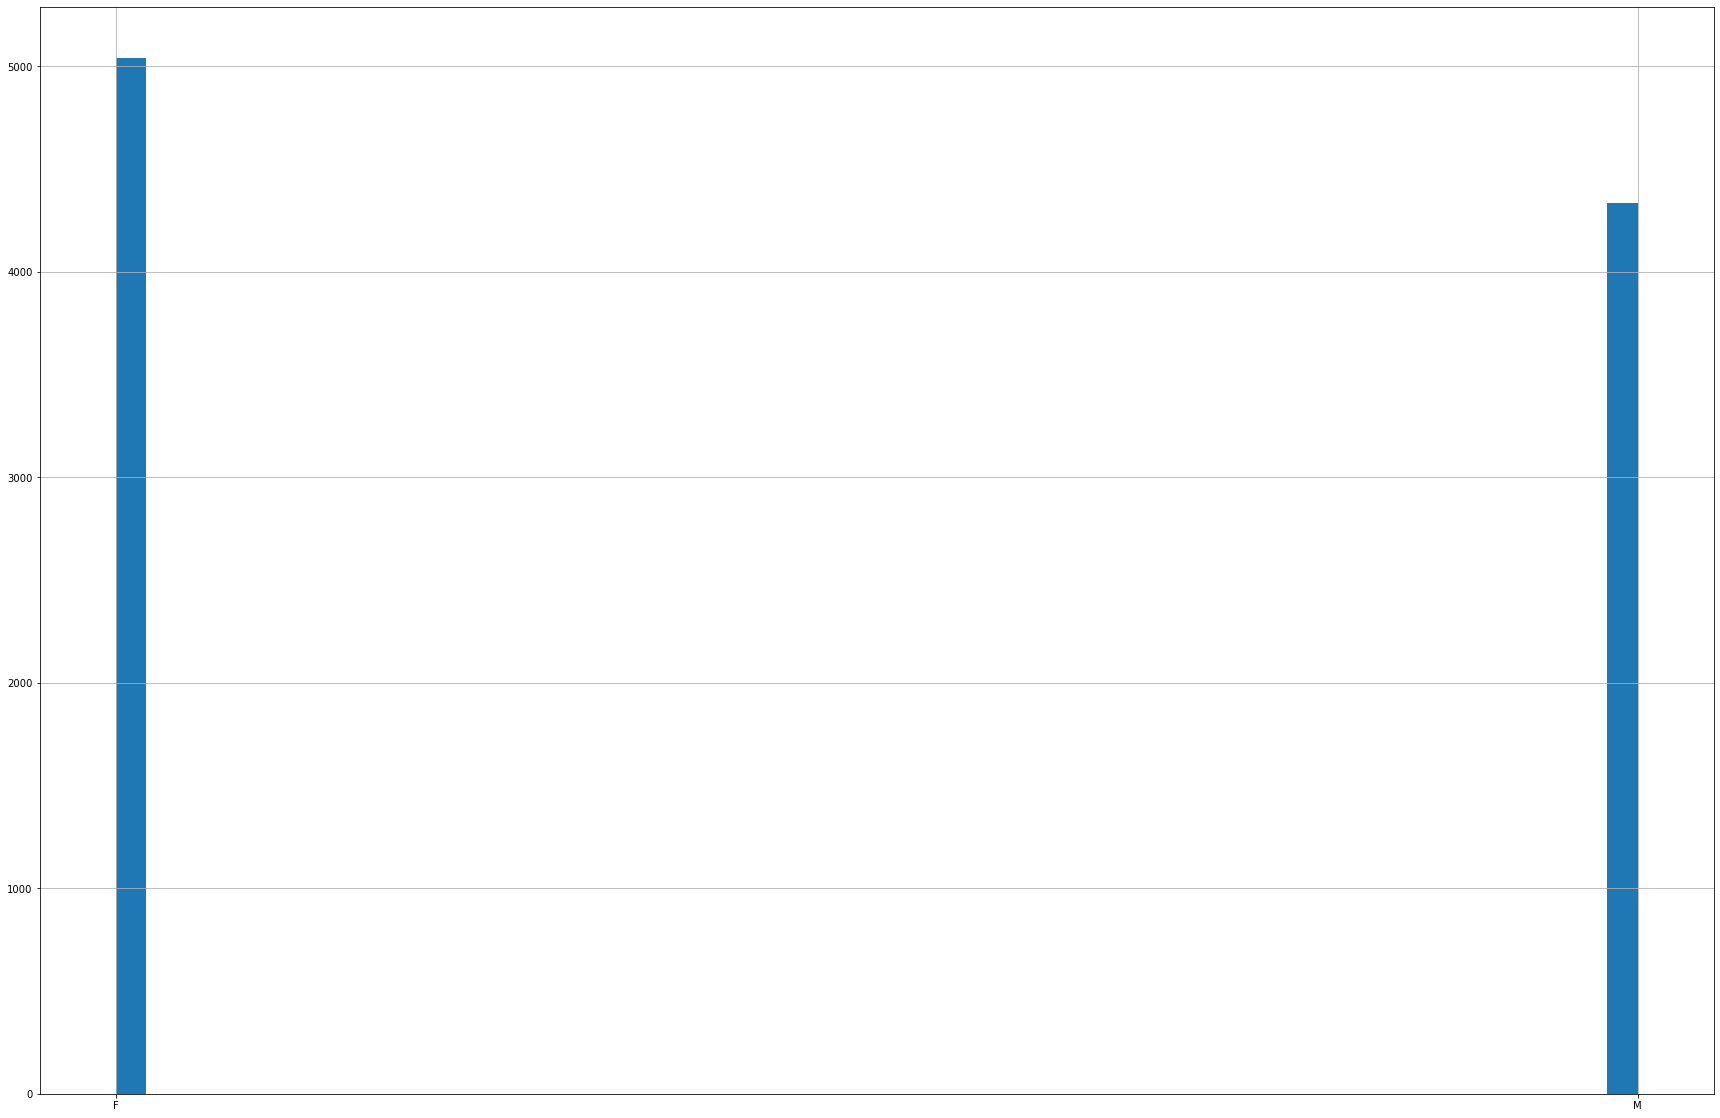

In [4506]:
data['sex'][data['default'] == 1].hist(bins=50)

Почему - то получилось наоборот. ну да и ладно)

In [4507]:
data['female_default'] = 0
data['female_default'] = np.where((data['sex'] == 'F') & (data['income'] < data['income'].mean()) & (data['score_bki'] < data['score_bki'].mean()), '1', data['female_default'] )
data['female_default'] = data['female_default'].astype(int)

In [4508]:
data.female_default.value_counts()

0    85356
1    24792
Name: female_default, dtype: int64

In [4509]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           110148 non-null  int64  
 1   app_date            110148 non-null  int64  
 2   education           110148 non-null  object 
 3   sex                 110148 non-null  object 
 4   age                 110148 non-null  int64  
 5   car                 110148 non-null  object 
 6   car_type            110148 non-null  object 
 7   decline_app_cnt     110148 non-null  int64  
 8   good_work           110148 non-null  int64  
 9   score_bki           110148 non-null  float64
 10  bki_request_cnt     110148 non-null  int64  
 11  region_rating       110148 non-null  int64  
 12  home_address        110148 non-null  int64  
 13  work_address        110148 non-null  int64  
 14  income              110148 non-null  int64  
 15  sna                 110148 non-nul

In [4510]:
data['male_default'] = 0
data['male_default'] = np.where((data['sex'] == 'M') & (data['age'] < data['age'].mean()) & (data['good_work'] == 0), '1', data['male_default'] )
data['male_default'] = data['male_default'].astype(int)

# 4. 

In [4511]:
# определение границ выбросов
median = data.income.median()
IQR = data.income.quantile(0.75) - data.income.quantile(0.25)
perc25 = data.income.quantile(0.25)
perc75 = data.income.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].


In [4512]:
data['income'] = np.where(data['income']>90000.0,data['income'].median(), data['income'])

In [4513]:
data['income'] = np.where(data['income']<-22000.0,data['income'].median(), data['income'])

# 5. 

In [4514]:
data['whithout_default'] = 0
data['whithout_default'] = np.where((data['good_work'] == 1) & (data['car_type'] =='Y') , '1', data['whithout_default'] )
data['whithout_default'] = data['whithout_default'].astype(int)

In [4515]:
data['whithout_default2'] = 0
data['whithout_default2'] = np.where((data['foreign_passport'] == 'Y') & (data['car_type'] =='Y') , '1', data['whithout_default2'] )
data['whithout_default2'] = data['whithout_default2'].astype(int)

In [4516]:
data['whithout_default3'] = 0
data['whithout_default3'] = np.where((data['decline_app_cnt'] == 0) & (data['bki_request_cnt'] == 0)& (data['income'] > data['income'].mean()) , '1', data['whithout_default3'] )
data['whithout_default3'] = data['whithout_default3'].astype(int)

# 3. Подготовка данных для обучения.

In [4517]:
# На основании графиков можно сделать следующие преобразования:

data['age'] = np.log(data['age'] + 1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)




Для бинарных переменных используем LabelEncoder. # bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [4518]:
label_encoder = LabelEncoder()

In [4519]:
data['sex'] = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [4520]:
data['car'] = pd.Series(label_encoder.fit_transform(data['car']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


In [4521]:
data['car_type'] = pd.Series(label_encoder.fit_transform(data['car_type']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


In [4522]:
data['foreign_passport'] = pd.Series(label_encoder.fit_transform(data['foreign_passport']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


Значений типа object в нашем датасете больше нет (кроме app_date).

Проверим на сколько изменится score.

score 0.72755

In [4523]:
# реализуем метод OneHotLabels через get_dummies для категориальных признаков кроме "education"
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

data=pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [4524]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           110148 non-null  int64  
 1   app_date            110148 non-null  int64  
 2   sex                 110148 non-null  int64  
 3   age                 110148 non-null  float64
 4   car                 110148 non-null  int64  
 5   car_type            110148 non-null  int64  
 6   decline_app_cnt     110148 non-null  float64
 7   good_work           110148 non-null  int64  
 8   score_bki           110148 non-null  float64
 9   bki_request_cnt     110148 non-null  float64
 10  income              110148 non-null  float64
 11  foreign_passport    110148 non-null  int64  
 12  sample              110148 non-null  int64  
 13  default             110148 non-null  int64  
 14  region_rating_freq  110148 non-null  float64
 15  day_num             110148 non-nul

После применения undersampling score  составил 0.73084

In [4525]:
def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'default'], data.loc[data.loc[:, column] == comb[1], 'default']).pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [4526]:
list(data.columns.values)

['client_id',
 'app_date',
 'sex',
 'age',
 'car',
 'car_type',
 'decline_app_cnt',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'income',
 'foreign_passport',
 'sample',
 'default',
 'region_rating_freq',
 'day_num',
 'female_default',
 'male_default',
 'whithout_default',
 'whithout_default2',
 'whithout_default3',
 'education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4']

In [4527]:
cat_cols

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time']

In [4528]:
bin_cols

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [4529]:
for cols in ['education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR','region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80','home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3', 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4', 'female_default', 'whithout_default', 'whithout_default2', 'male_default', 'whithout_default3' ]:
    get_stat_dif(cols)
 

Найдены статистически значимые различия для колонки education_ACD
Найдены статистически значимые различия для колонки education_GRD
Найдены статистически значимые различия для колонки education_PGR
Найдены статистически значимые различия для колонки education_SCH
Найдены статистически значимые различия для колонки region_rating_20
Найдены статистически значимые различия для колонки region_rating_30
Найдены статистически значимые различия для колонки region_rating_40
Найдены статистически значимые различия для колонки region_rating_50
Найдены статистически значимые различия для колонки region_rating_70
Найдены статистически значимые различия для колонки region_rating_80
Найдены статистически значимые различия для колонки home_address_1
Найдены статистически значимые различия для колонки home_address_2
Найдены статистически значимые различия для колонки work_address_1
Найдены статистически значимые различия для колонки work_address_2
Найдены статистически значимые различия для колонки wo

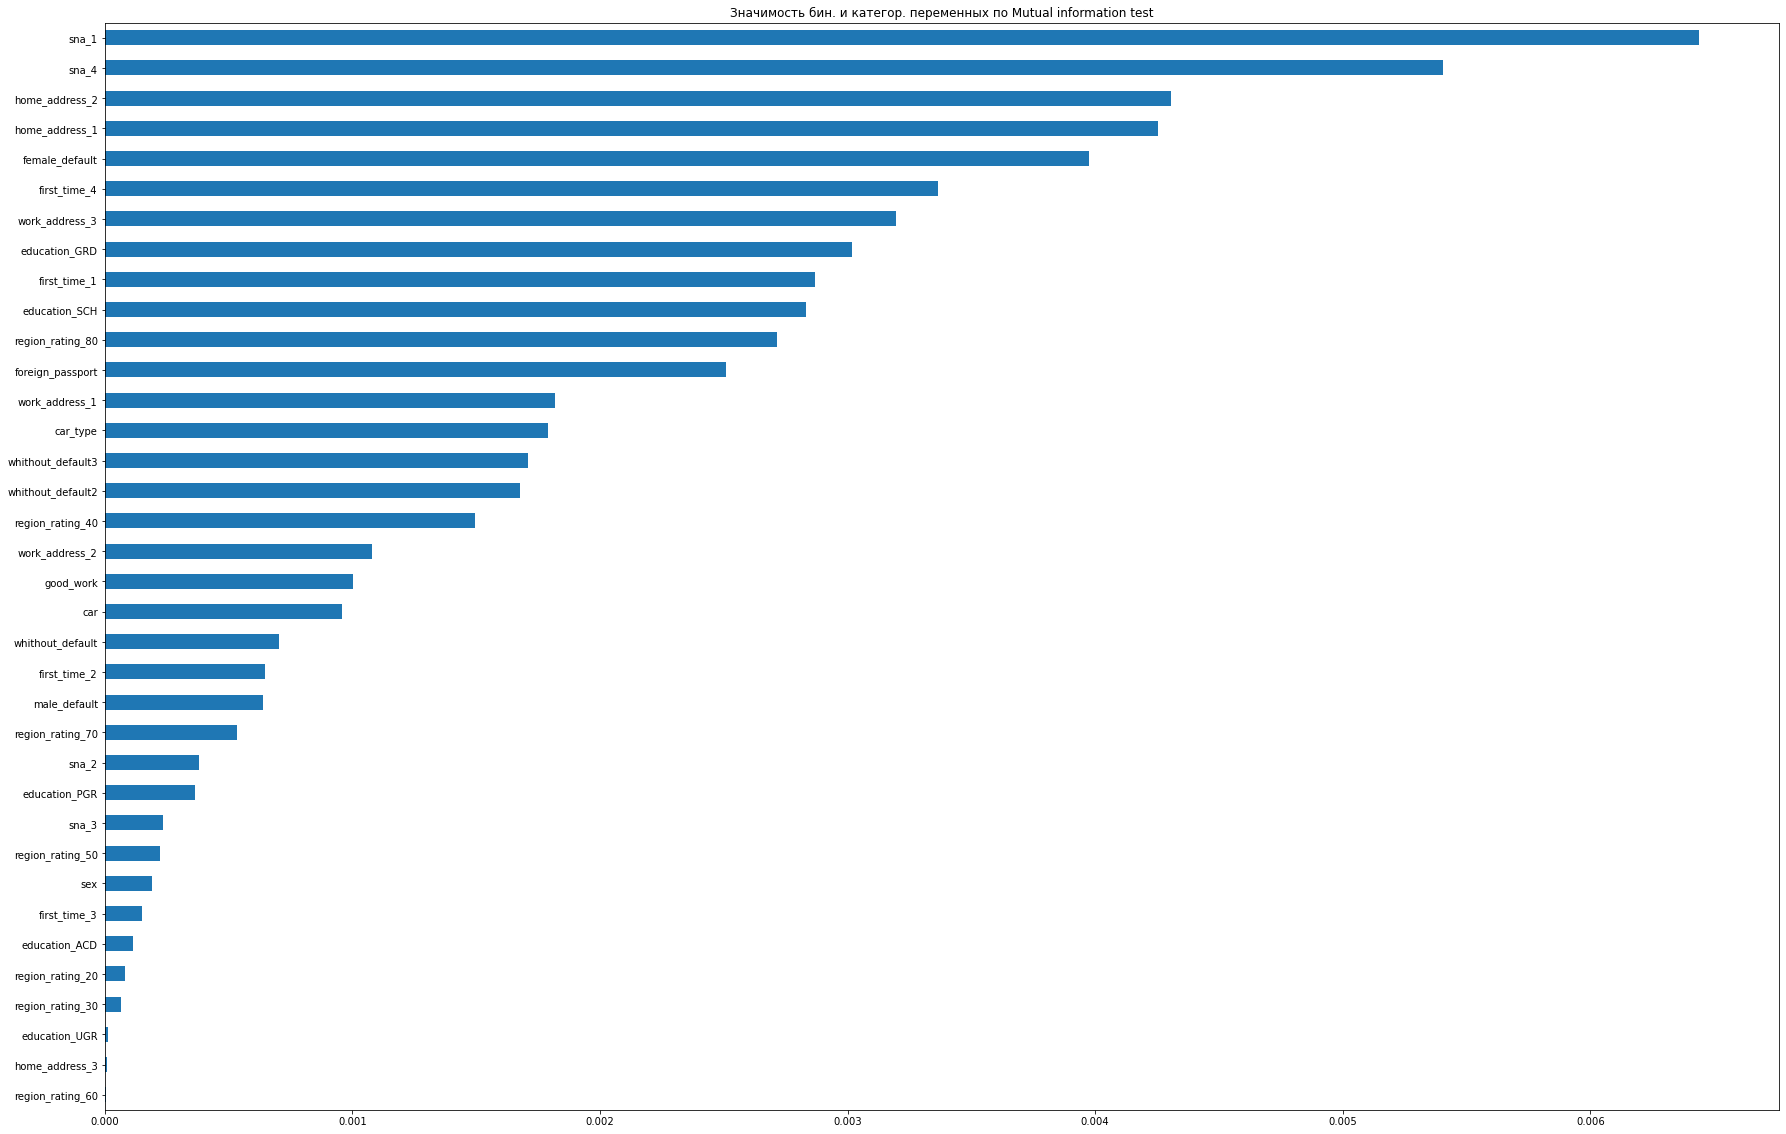

In [4530]:
all_cat_and_bin_cols = ['education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR','region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80','home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3', 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4', 'sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'female_default','male_default', 'whithout_default', 'whithout_default2', 'whithout_default3']
temp_df = data[data['sample']==1]
imp_cat = pd.Series(mutual_info_classif(temp_df[all_cat_and_bin_cols], temp_df['default'], discrete_features =True), index = all_cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test')

Наиболее значимым признаком среди категориальных и бинарных является sna - связь заемщика с клиентами банка.

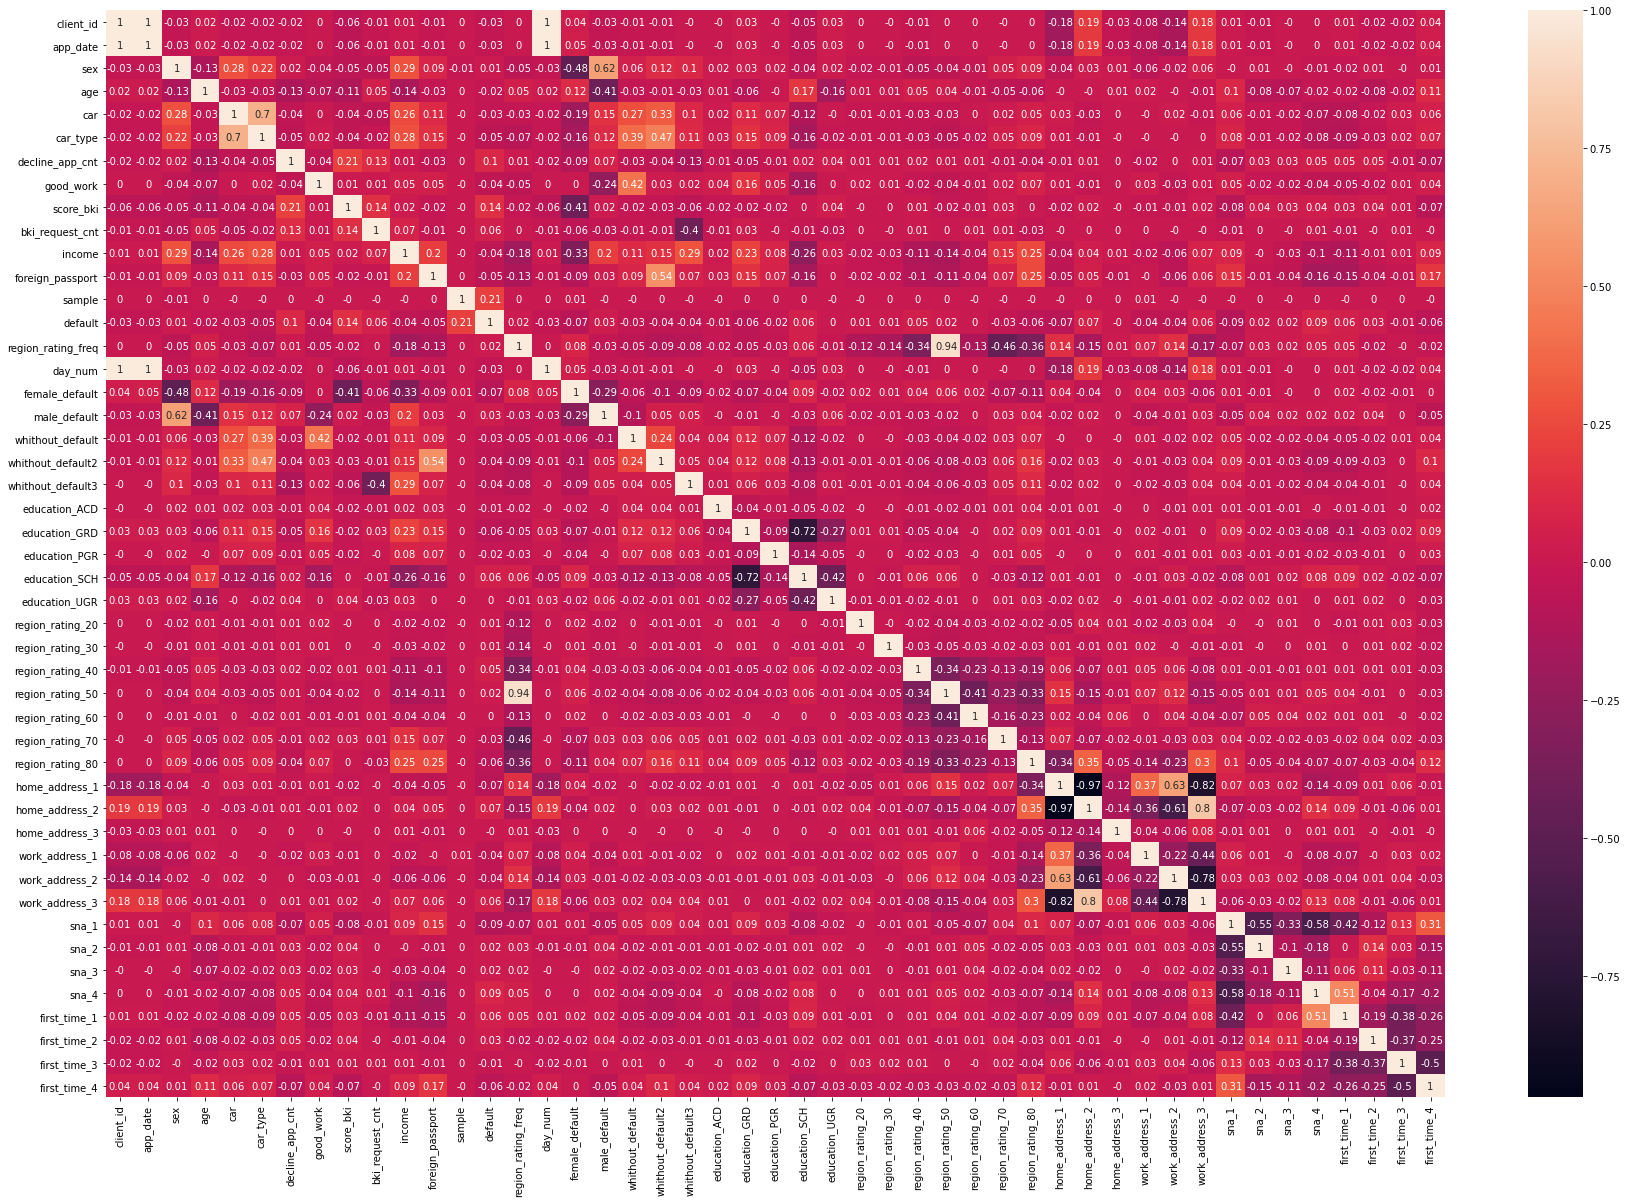

In [4531]:
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data.corr().round(2), annot = True) 

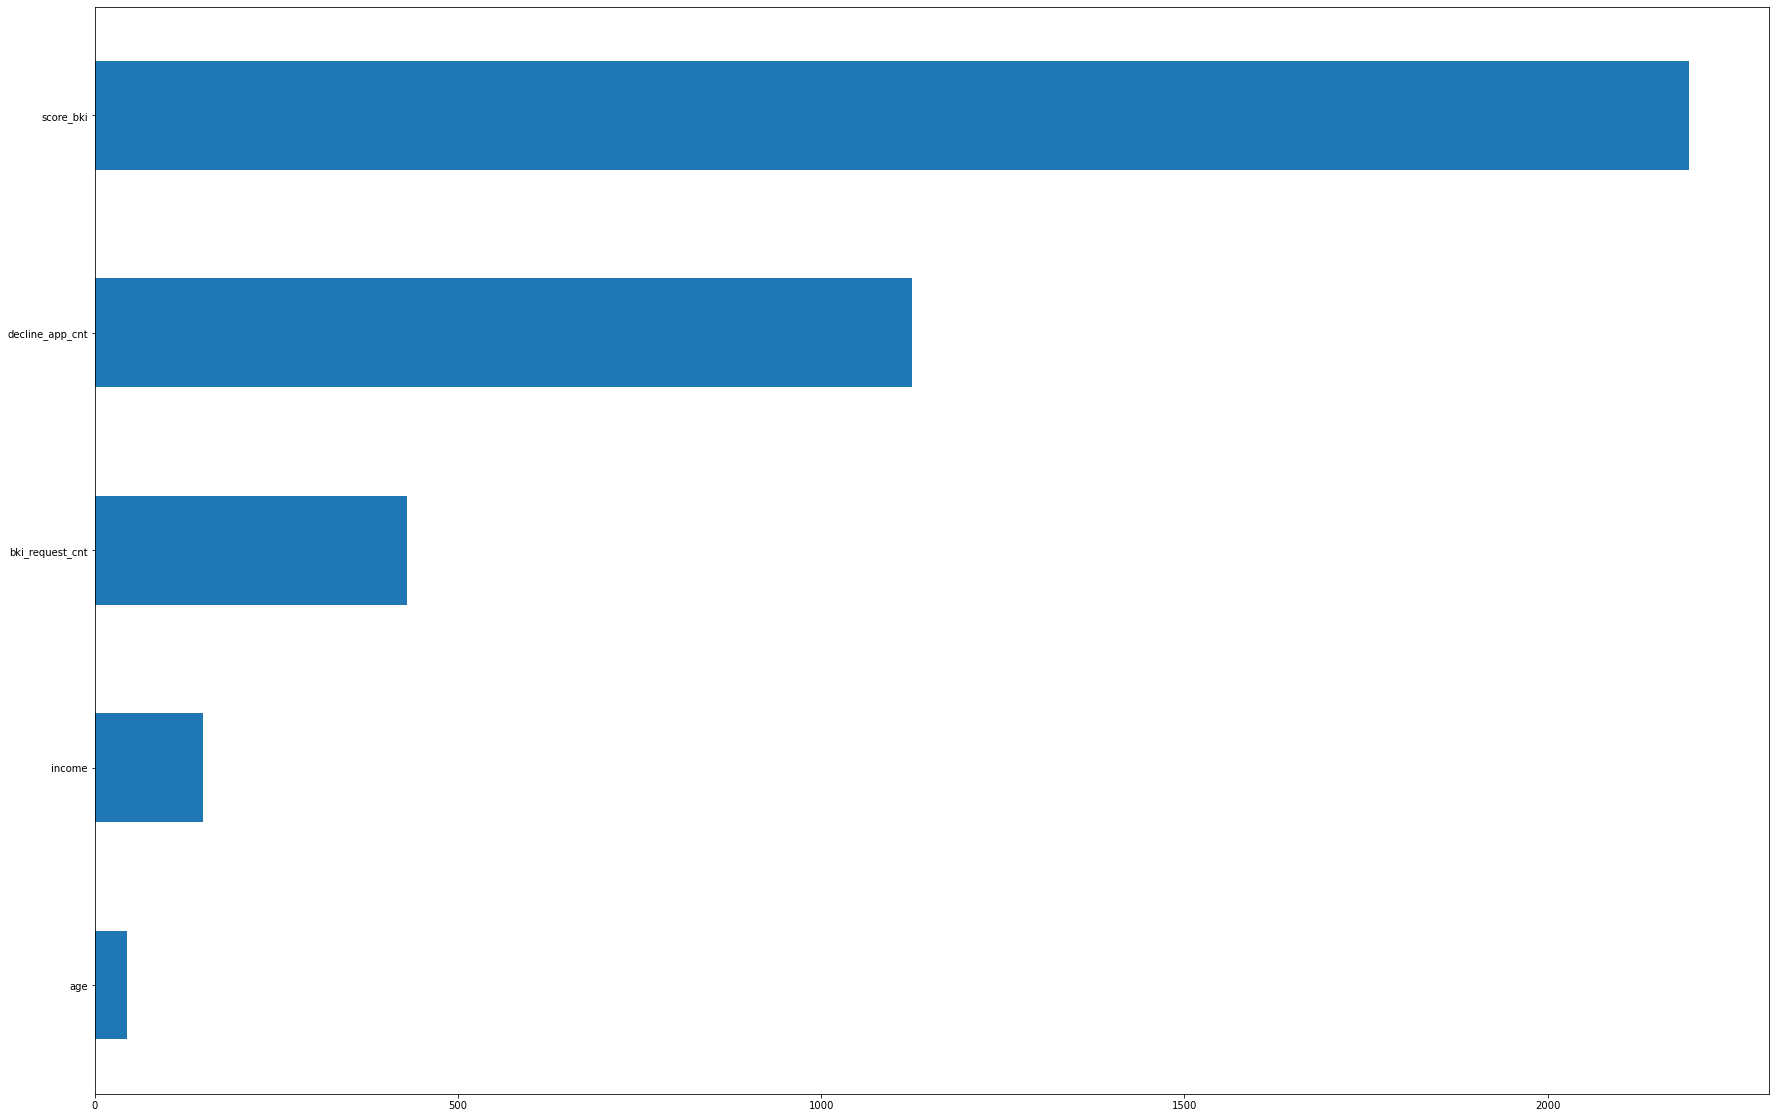

In [4532]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [4533]:
# data.drop(['education_UGR','education_SCH','app_date','education_GRD', 'region_rating_60','region_rating_50', 'home_address_1', 'work_address_3','work_address_1', 'work_address_2'], axis='columns', inplace=True)

In [4534]:
list(data.columns.values)

['client_id',
 'app_date',
 'sex',
 'age',
 'car',
 'car_type',
 'decline_app_cnt',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'income',
 'foreign_passport',
 'sample',
 'default',
 'region_rating_freq',
 'day_num',
 'female_default',
 'male_default',
 'whithout_default',
 'whithout_default2',
 'whithout_default3',
 'education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4']

In [4535]:
data.drop(['education_UGR', 'first_time_3', 'car','sna_3','sna_2', 'education_SCH','app_date','education_GRD', 'region_rating_60','region_rating_50', 'home_address_1', 'work_address_3','work_address_1', 'work_address_2'], axis='columns', inplace=True)

In [4536]:
# data['score_bki'] = data['score_bki']**2

In [4537]:
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income', 'day_num', 'region_rating_freq']
# num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income', 'region_rating_freq']


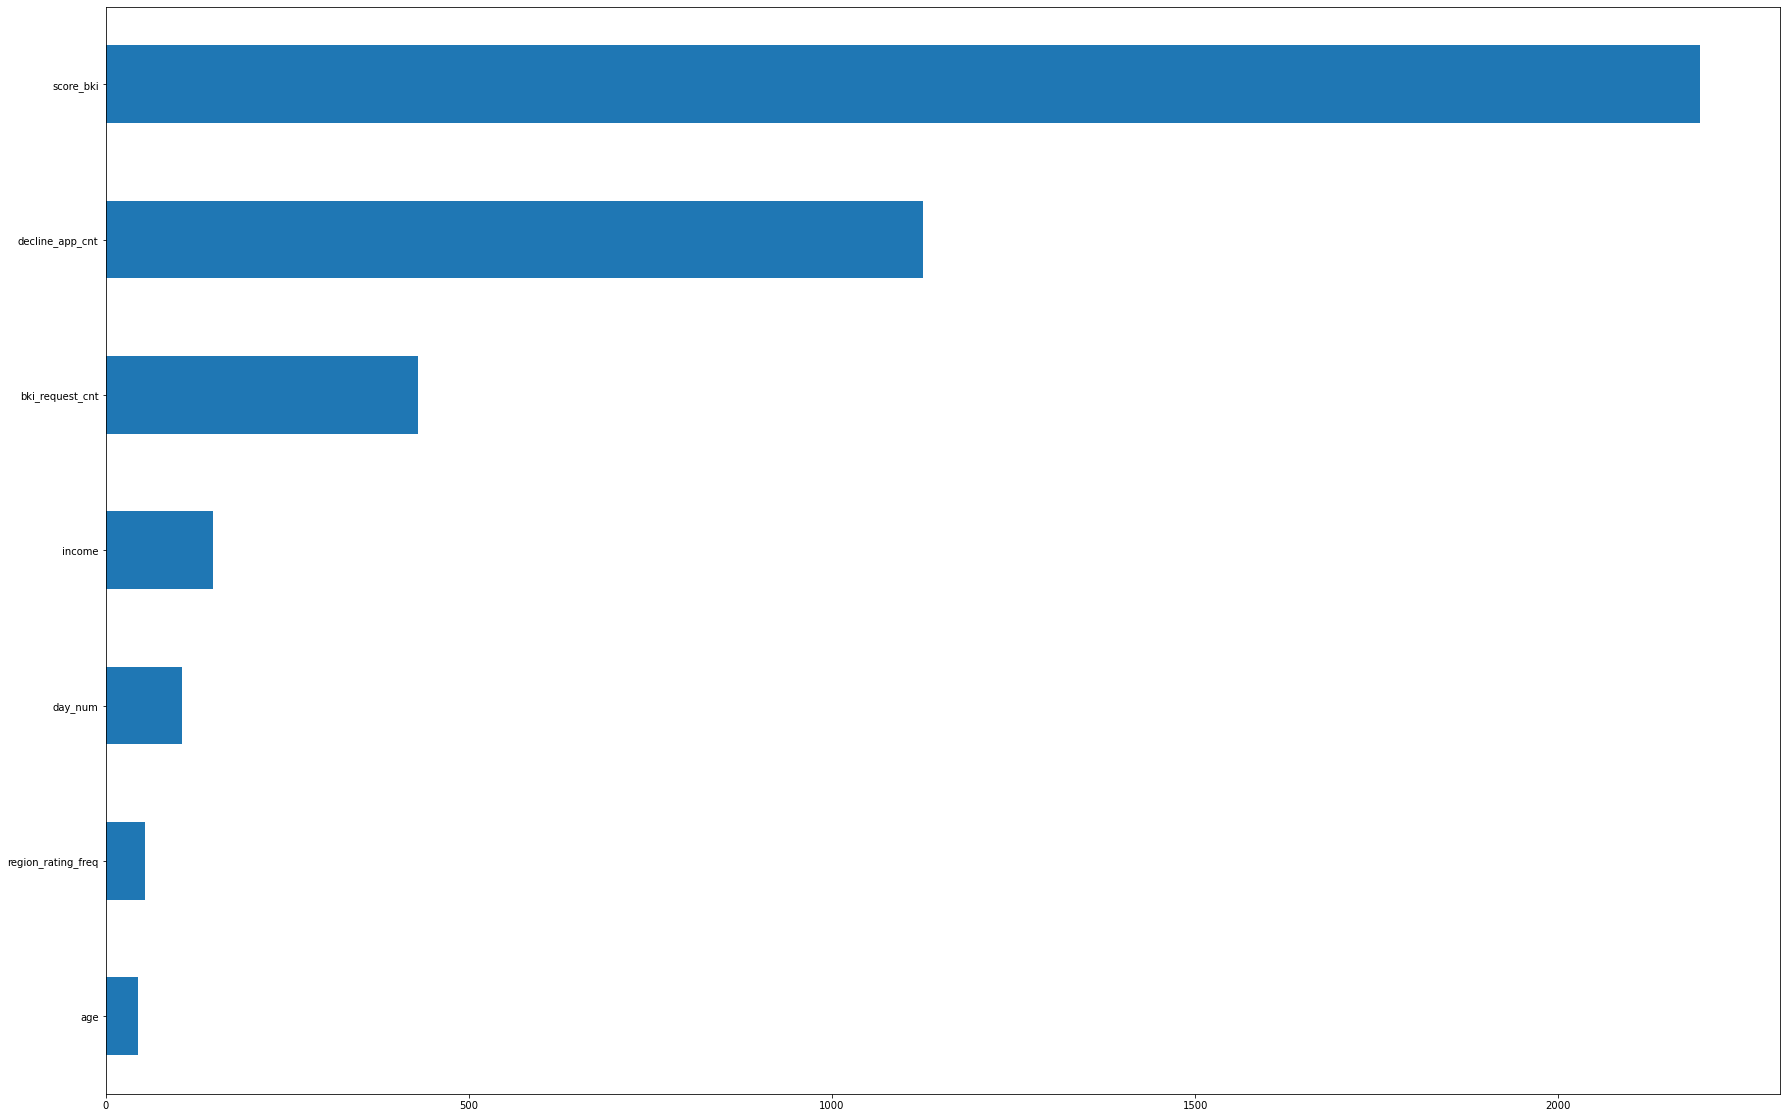

In [4538]:
# значимость переменных вместе с датой
all_time_and_num_cols = num_cols
# all_time_and_num_cols = num_cols+time_cols
imp_num = Series(f_classif(data[all_time_and_num_cols], data['default'])[0], index = all_time_and_num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')    

In [4539]:
#Стандартизация числовых переменных
data[all_time_and_num_cols] = StandardScaler().fit_transform(data[all_time_and_num_cols].values)

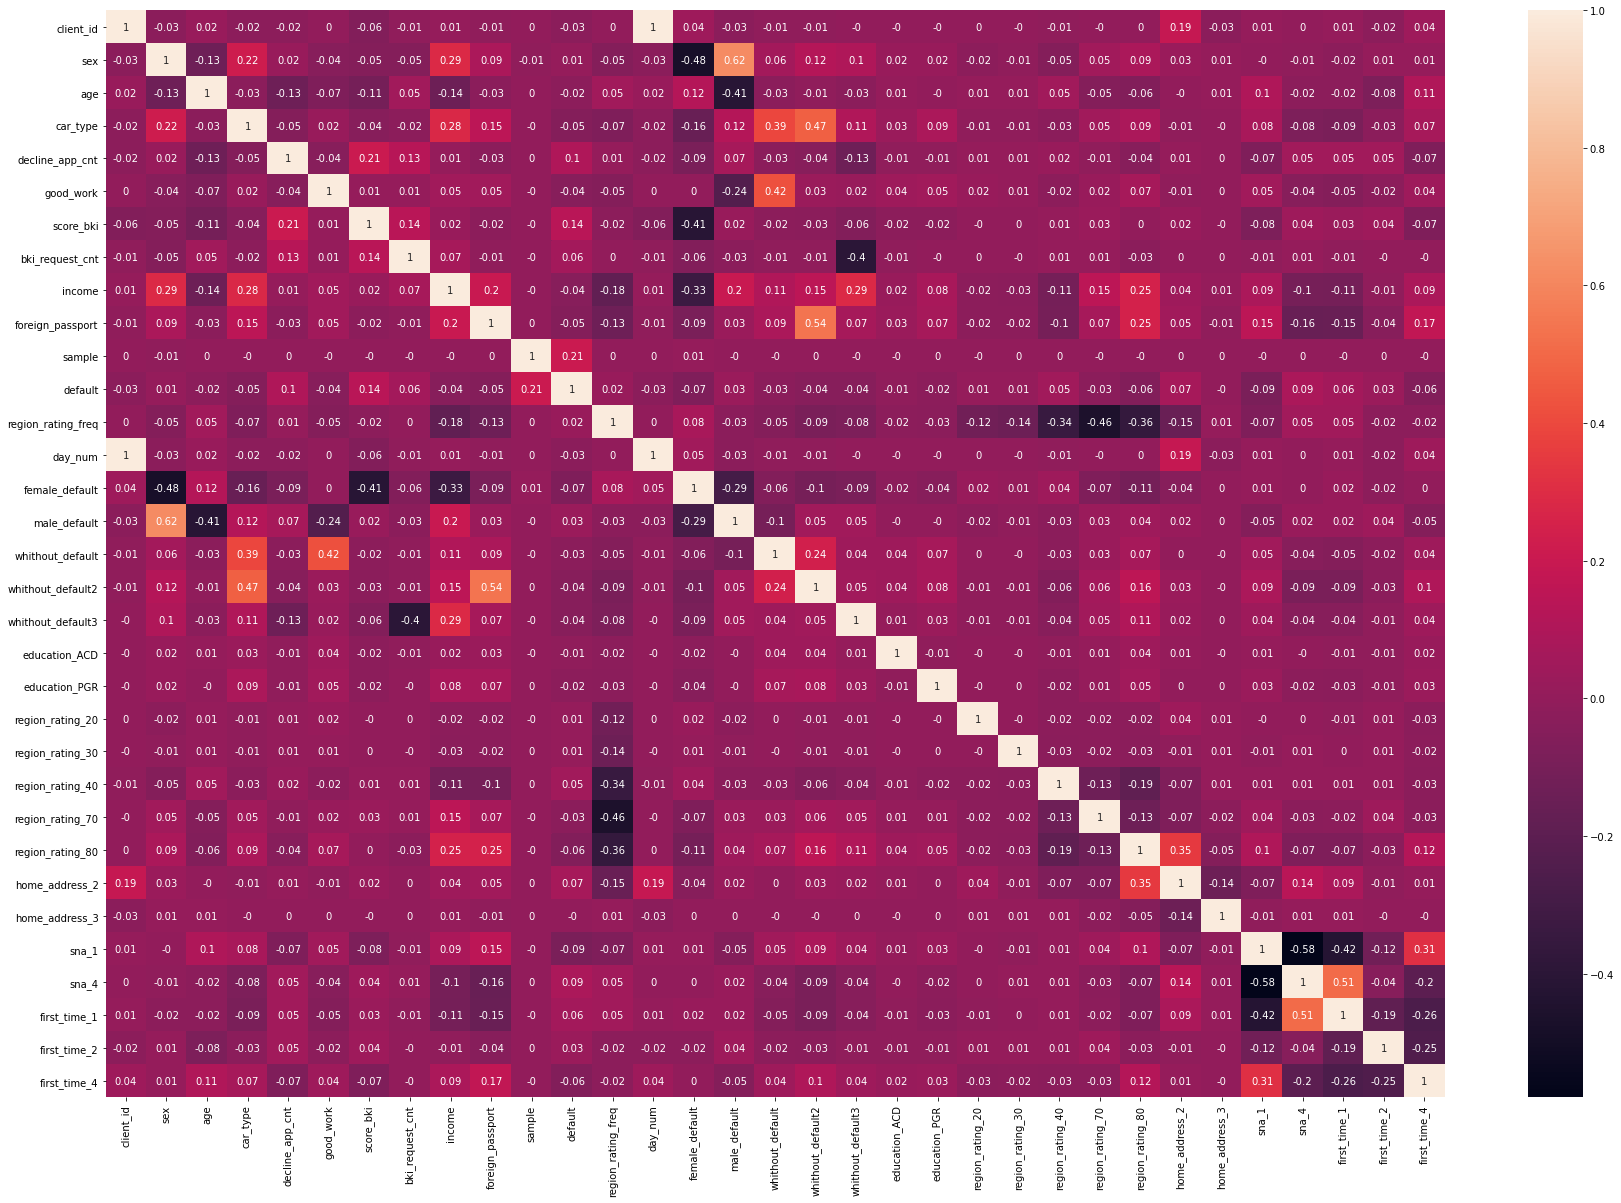

In [4540]:
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data.corr().round(2), annot = True) 

Учитывая что наша выборка является несбалансированной представляется целесообразным уменьшить количество объектов превалирующих классов (undersampling)

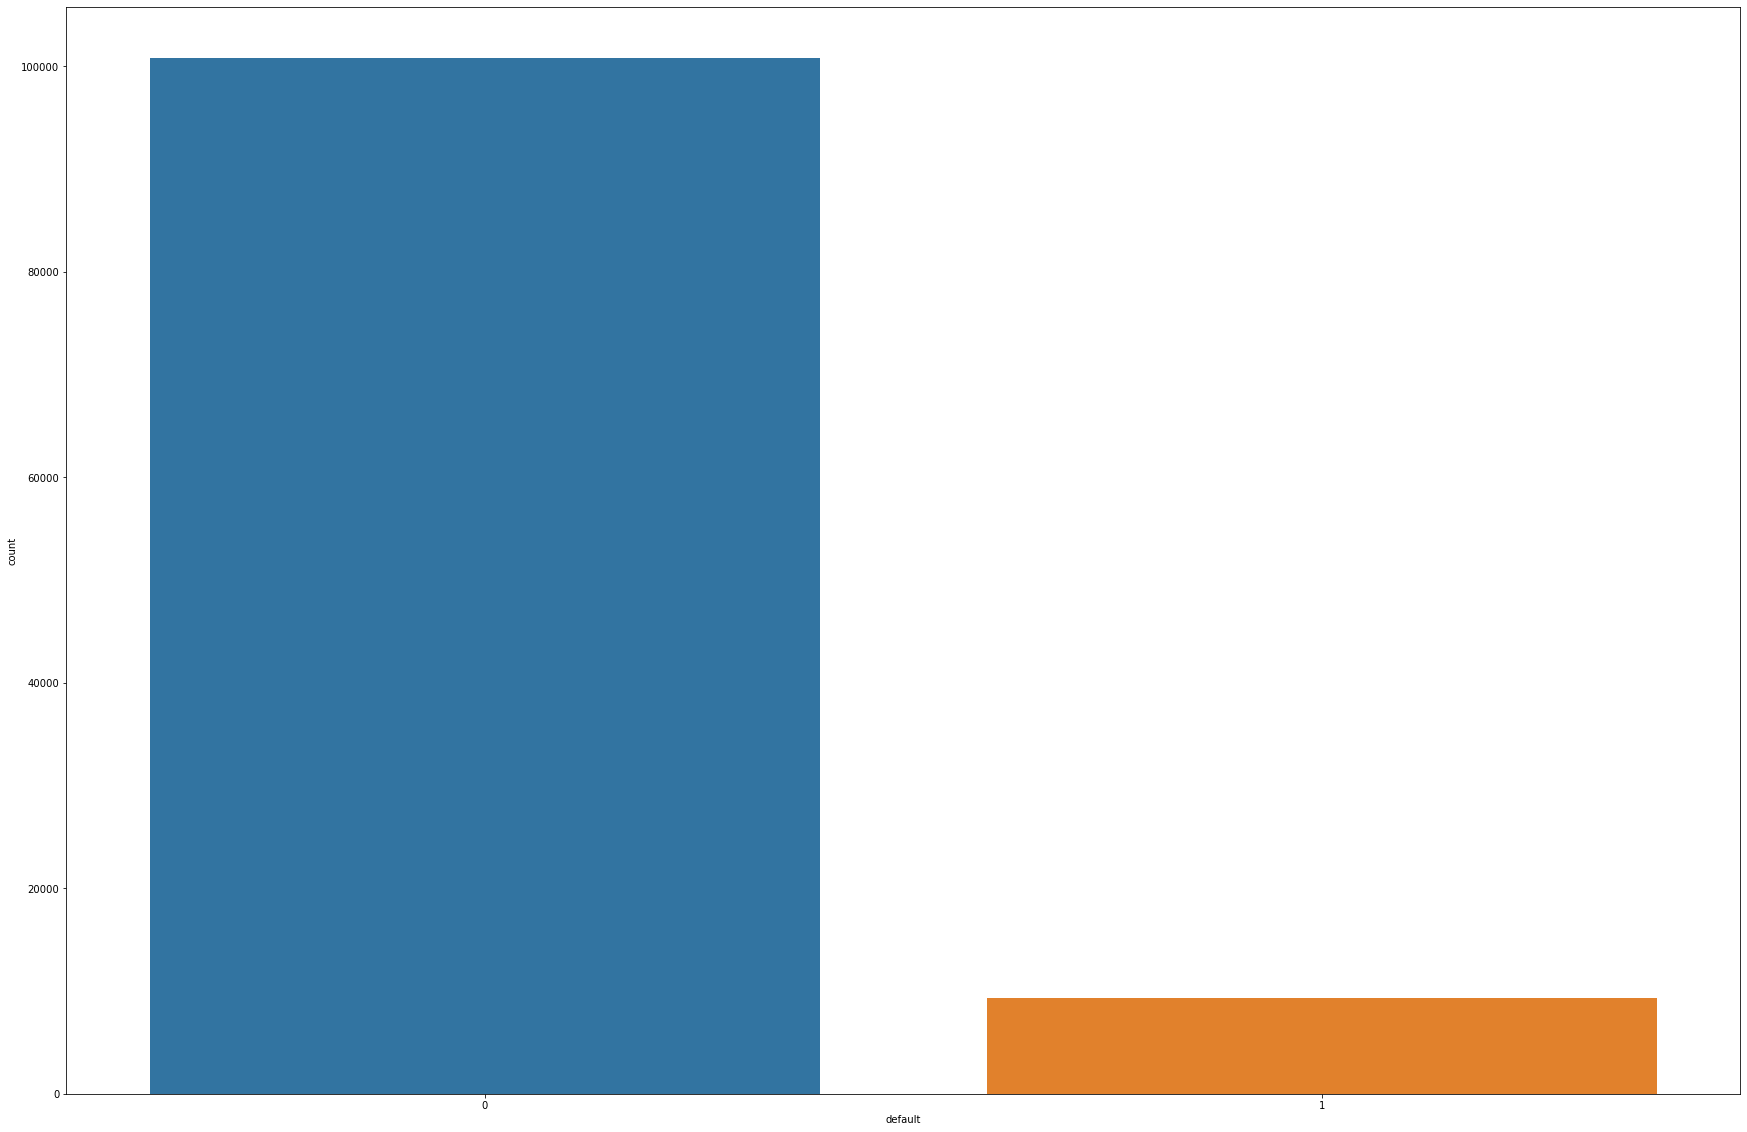

In [4541]:
sns.countplot(x='default', data=data)

In [4542]:
no_frauds = len(data[data['default'] == 1])

In [4543]:
non_fraud_indices = data[data.default == 0].index

In [4544]:
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)

In [4545]:
fraud_indices = data[data.default == 1].index

In [4546]:
under_sample_indices = np.concatenate([fraud_indices,random_indices])

In [4547]:
under_sample = data.loc[under_sample_indices]

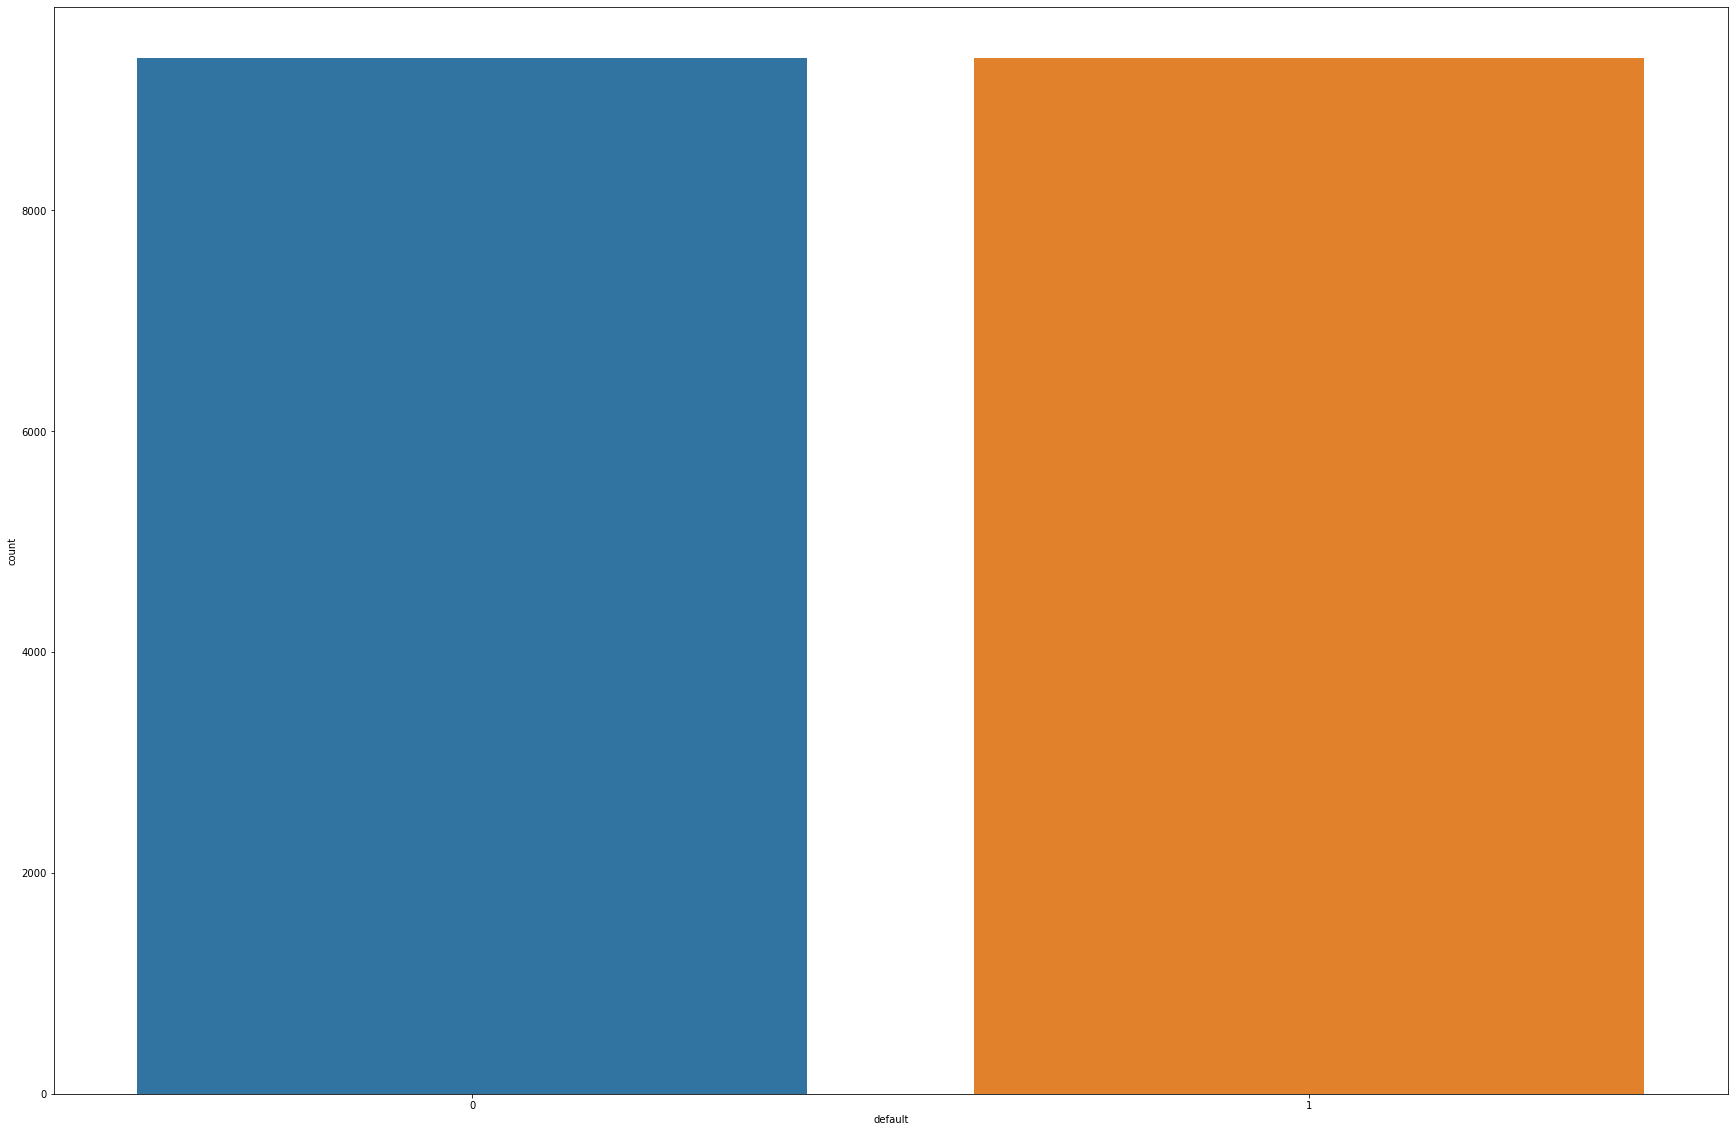

In [4548]:
sns.countplot(x='default', data=under_sample)

In [4549]:
# Обучим модель на сбалансированной выборке.
train_data = under_sample.query('sample == 1').drop(['sample', 'client_id'], axis=1)

test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [4550]:
# Действие относится к первым 3 попыткам.
#train_data = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
#test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [4551]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)
y_test = test_data.default.values

In [4552]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36349, 31), (15297, 31), (15297, 30), (15297,), (36349, 30), (36349,))

Логистическая модель в sklearn реализована в классе LogisticRegression библиотеки linear_model.

In [4553]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    # метод для поиска решения. Для небольших датасетов лучше подходит liblinear, sag и saga -- для больших.
    # Варианты: newton-cg, lbfgs, liblinear, sag, saga
    solver='sag',
    # норма для регуляризации. Варианты: l2, l1.
    penalty='l2',
    # параметр регуляризации. Чем меньше, тем сильнее регуляризация. Положительный.
    C=1,
    # параметр для остановки поиска решения.
    tol=0.001,
    # Так как распознается 2 класса.
    multi_class='auto'
    )

In [4554]:
model.fit(X_train, y_train)

LogisticRegression(C=1, solver='sag', tol=0.001)

In [4555]:
preds = model.predict(X_train)

In [4556]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score 

model = LogisticRegression(random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = model.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(y_train, preds))
print('Precision: %.4f' % precision_score(y_train, preds))
print('Recall: %.4f' % recall_score(y_train, preds))
print('F1: %.4f' % f1_score(y_train, preds))

	C: 1.0
	class_weight: 'none'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: Found input variables with inconsistent numbers of samples: [15297, 36349]

In [ ]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y_train, preds)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

Судя по данным confusion_matrix у нас 9 тысяч ложно отрицательных значения. (дефолт классифицирован как не-дефолт) 



Комментарий относится к первым 3 попыткам. После обучения модели на сбалансированной выборке количество ложно отрицательных значений снизилось, зато увеличилось количество лолжно положительных значений
(не-дефолт классифицирован как дефолт).

In [ ]:
pred_prob = model.predict_proba(X_train)

In [ ]:
preds = pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)


In [ ]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [ ]:
y_pred_prob = model.predict_proba(X_test)[:,1]


submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)